<a href="https://colab.research.google.com/github/RehamJamal13/model/blob/main/Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Download pakages
#NATURAL LANGUAGE PROCESSING

#1. NLTK

#!pip install nltk
import nltk as nlp
#nltk.download()
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer

#2. SPACY
from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-2.0.0/en_core_web_md-2.0.0.tar.gz
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
#!pip install <model_s3_url> # tar.gz file e.g. from release notes like https://github.com/explosion/spacy-models/releases//tag/en_core_web_lg-2.3.1
#!pip install en_core_web_lg
#3 scispacy
!pip install scispacy

#4 langdetect To detect the language of the text:
!pip install langdetect
#5
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz
#6 pyresparser
!pip install pyresparser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 22.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 8.9 MB/s eta 0:00:00
  Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 117.1 MB/s eta 0:00:00
  Created wheel for nmslib: filename=nmslib-2.1.1-cp310-cp310-linux_x86_64.whl size=13544177 sha256=dc3d4448c8ba55b1626ba7793aa4e4519e2f01fa74aa77a9e75d1b391aed0ea8
  Stored in directory: /root/.cache/pip/wheels/21/1a/5d/4cc754a5b1a88405cad184b76f823897a63a8d19afcd4b9314
Successfully built nmslib
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.2
    Uninstalling wasabi-1.1.2:
      Successfully uninstalled wasabi-1.1.2
  Attempting uninstall: typer
    Found existing 

In [ ]:
#@title Load Packages
import numpy as np
import pandas as pd

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import scispacy
import spacy
#import en_core_sci_lg

from scipy.spatial.distance import jensenshannon

import joblib

from IPython.display import HTML, display

import os
import glob
import json
import re
import string
import networkx as nx
import gc

from IPython.utils import io
#with io.capture_output() as captured:

 # !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

from pprint import pprint
from copy import deepcopy

from collections import  Counter

from ipywidgets import interact, Layout, HBox, VBox, Box
import ipywidgets as widgets
from IPython.display import clear_output

from tqdm import tqdm
from os.path import isfile

import seaborn as sb
import matplotlib.pyplot as plt
plt.style.use("dark_background")

In [ ]:
#@title Load Data
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Bibliography_2016 - Sheet1.csv')

##Prpare Data and K-mean clustring

In [ ]:
#@title Prepare Data
df.head()

Record Number Author  Year  \
0          17394    NaN   NaN   
1          25899    NaN  1332   
2          25900    NaN  1884   
3          25901    NaN  1884   
4          25902    NaN  1908   

                                               Title   Reference Type  \
0  Female Genital Cutting and Infertility - NEJM ...  Journal Article   
1                                      وثيقة بيع أمة             Book   
2                                          The Sudan  Journal Article   
3                     The False Prophet of the Sudan  Journal Article   
4                    Chemotherapy of Trypanosomiasis  Journal Article   

   Journal Volume    Pages                                           Abstract  \
0      NaN    NaN      NaN  Female genital cutting (FGC; also called femal...   
1      NaN    NaN      NaN                                                NaN   
2  Science      4    530-1                                                NaN   
3  Science      3  199-200                                                NaN   
4     BSSB    NaN     1-49                                                NaN   

                 Keywords  
0  Female genital cutting  
1                     NaN  
2      Medical Miscellany  
3      Medical Miscellany  
4         Trypanosomiasis

In [ ]:
df.shape

(19186, 10)

In [ ]:
#Count NaN values under Title (TI) column :
df['Title'].isna().sum()

126

In [ ]:
#Take the rows where Title (TI) is NA:
df = df[df['Title'].notna()]

In [ ]:
#Filtered out non-English titles with langdetect
from langdetect import detect
def detect_english(text):
   try:
    return detect(text) == 'en'
   except:
    return False

df = df[df['Title'].apply(detect_english)]

In [ ]:
#Remove Duplicate Rows Using DataFrame.apply() and Lambda Function
df2 = df.apply(lambda x: x.astype(str).str.lower()).drop_duplicates(subset=['Title'],keep='first')

In [ ]:
len(df['Title'].unique())

13308

In [ ]:
# change column name
df2.rename(columns = {'Title':'TITLE'}, inplace = True)
# consider the Title
new_data = df2.TITLE
#save data
df2.to_csv('/content/drive/MyDrive/Colab_Notebooks/Bibliography_EN.csv')

In [ ]:
df2['TITLE'].describe(include='all')

count                                                 13153
unique                                                13153
top       female genital cutting and infertility - nejm ...
freq                                                      1
Name: TITLE, dtype: object

In [ ]:
#@title preprocessing
#For preprocessing we use scispaCy, which is a Python package containing spaCy models for processing biomedical, scientific or clinical text.
#Use ScispaCy’s (a spaCy package) “en_core_sci_lg” model for biomedical, scientific, and clinical vocabulary to do parts of speech tagging
from spacy.lang.en.stop_words import STOP_WORDS
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure',
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.',
    'al.', 'Elsevier', 'PMC', 'CZI', 'www','99m','450','15'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)
stopwords = stopwords + ['mr', 'mrs', 'family','come', 'go', 'get', 'tell', 'listen', 'one', 'two', 'three', 'four',
                         'five', 'six', 'seven', 'eight', 'nine', 'zero', 'join', 'find', 'make', 'say',
                         'ask', 'tell', 'see', 'try', 'back', 'also','movie',
                         '1','2','3','4','5','6','7','8','9','10','0',
                         'film', 'movie', 'watch', 'cinema', 'scene','action', 'fighting','story', '3D'
                         'show', 'get','tell', 'listen']

In [ ]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
#!pip install en_core_web_lg
#import spacy
import en_core_web_lg
import en_core_web_lg
tagger = en_core_web_lg.load(disable=["parser", "ner"]) # review
tagger.max_length = 7000000
"""sentence = "[The epidemiology of malaria in Bursa--2009-2012]"
mytokens = parser(sentence)
txt=[]
for word in mytokens:
    txt.append(word.pos_)
print(txt)"""
def spacy_tokenizer(sentence,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    mytokens = tagger(sentence)
    mytokens = [ word for word in mytokens if word.text not in stopwords and word.text not in punctuations and word.pos_ in allowed_postags]
    mytokens = " ".join([str(i) for i in mytokens])
    return mytokens

tqdm.pandas()
df2["processed_title"] = df2["TITLE"].progress_apply(spacy_tokenizer)
#ADD document id column
df['DOC_ID']=df.index
df.to_csv('/content/drive/MyDrive/Colab_Notebooks/Bibliography_DOCID.csv')

⚠ Skipping model package dependencies and setting `--no-deps`. You
don't seem to have the spaCy package itself installed (maybe because you've
built from source?), so installing the model dependencies would cause spaCy to
be downloaded, which probably isn't what you want. If the model package has
other dependencies, you'll have to install them manually.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


100%|██████████| 13153/13153 [01:16<00:00, 172.26it/s]


In [ ]:
#@title Vectorization
# TF-IF
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    vectorizer = TfidfVectorizer(analyzer='word',stop_words= stopwords, max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return vectorizer, X
#text = df['processed_title']
text = df2["processed_title"].values
vectorizer,X = vectorize(text, 2 ** 12)
X.shape

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['3dshow', 'czi', 'elsevier', 'll', 'pmc', 've'] not in stop_words.
  warnings.warn(


(13140, 4096)

<Axes: ylabel='word'>

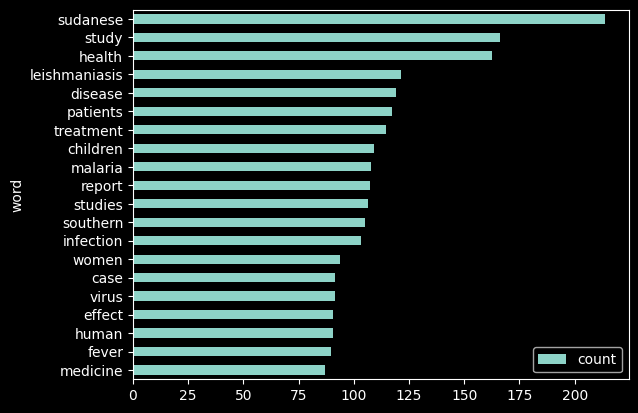

In [ ]:
# most frequent words(first 20)
from sklearn.feature_extraction.text import CountVectorizer

# show document feature vectors
vocabulary = vectorizer.get_feature_names_out()
# Creating the Bag of Words model
word_count = pd.DataFrame({'word': vocabulary, 'count': np.asarray(X.sum(axis=0))[0]})
word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh')




In [ ]:
joblib.dump(vectorizer, 'vectorizer.csv')
joblib.dump(X , 'data_vectorized.csv')

['data_vectorized.csv']

In [ ]:
# Run K_Means
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
# standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_reduced = scaler.fit_transform(X.toarray())
k = 40
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
#df2['y'] = y_pred
df2['TOPIC_ID'] = y_pred
df2.to_csv('/content/drive/MyDrive/Colab_Notebooks/Bibliography_DOCID.csv')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
dists = cdist(X.toarray(),kmeans.cluster_centers_,metric='euclidean')
dists

array([[66.18957724, 18.41617035, 16.85537458, ..., 32.46535217,
        64.21537039, 62.835807  ],
       [66.18010381, 18.3820928 , 16.82624351, ..., 32.44603361,
        64.20560567, 62.82582786],
       [66.1878821 , 18.41007692, 16.8568107 , ..., 32.46189602,
        64.21362314, 62.83402138],
       ...,
       [66.19070689, 18.39184315, 16.84733935, ..., 32.45176482,
        64.21653478, 62.83699695],
       [66.18884247, 18.40649554, 16.8605812 , ..., 32.46385413,
        64.21461304, 62.83503302],
       [66.18923248, 18.41493123, 16.85570685, ..., 32.46464929,
        64.21501504, 62.83544384]])

In [ ]:
#@title  KMeans Clustering Reinforced With Doc2Vec
data = doc2vec
# importing KMeans library of sklearn
from sklearn.cluster import KMeans

def kmeans(n_clusters):
    kmean_model = KMeans(n_clusters = n_clusters,random_state=0)
    return kmean_model

In [ ]:
kmeans.cluster_centers_

array([[-0.02063989, -0.01510608, -0.03228024, ..., -0.0372539 ,
        -0.03896596, -0.02439968],
       [-0.02063989, -0.01510608, -0.03228024, ..., -0.0372539 ,
        -0.03896596, -0.02439968],
       [ 0.60728814, -0.01510608, -0.03228024, ..., -0.0372539 ,
         0.26703164, -0.02439968],
       ...,
       [-0.02063989, -0.01510608, -0.03228024, ..., -0.0372539 ,
        -0.03896596, -0.02439968],
       [-0.02063989, -0.01510608, -0.03228024, ..., -0.0372539 ,
        -0.03896596, -0.02439968],
       [-0.02063989, -0.01510608, -0.03228024, ..., -0.0372539 ,
        -0.03896596, -0.02439968]])

In [ ]:
kmeans.inertia_

52964444.96668133

In [ ]:
centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(k):
    print("Cluster %d:" % i, end='')
    for ind in centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: metastases alveolar predict differentiated reliable ultrastructural bone indicator significant lung
Cluster 1: irrigated gezira scheme sulphate atherogenic area copper swine snail diet
Cluster 2: school deficit hyperactivity attention secondary children aged teachers regular epilepsy
Cluster 3: cytochrome p450 carcinogenic peroxidase aminoazo microsomes oxidation adducts isothermal midge
Cluster 4: times palaeopathology uncertainty thoracic position medieval ancient influenced processes forage
Cluster 5: meningitis bacterial meningococcal cerebrospinal moringa polysaccharide oleifera epidemic sequelae contamination
Cluster 6: leishmaniasis fever visceral yellow studies genital human onchocerciasis eradication african
Cluster 7: ammonia epithelium rumen transport urea modulation dependent sheep diet isolated
Cluster 8: peritonitis peritoneal multicenter continuous dialysis rates conventional improved patient program
Cluster 9: dimethyl ether leaves factory starch concentrated

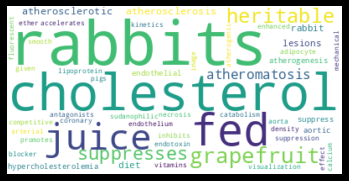

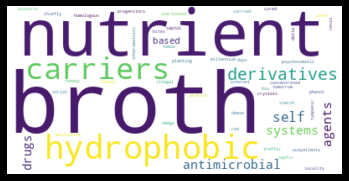

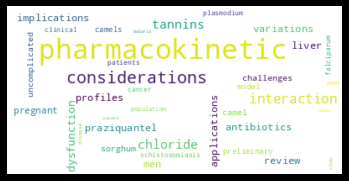

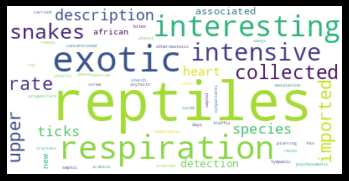

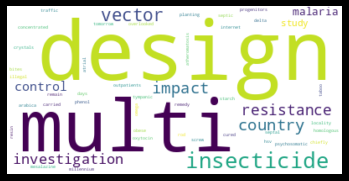

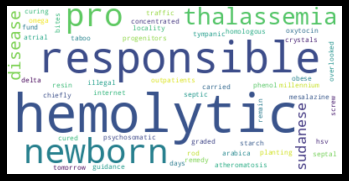

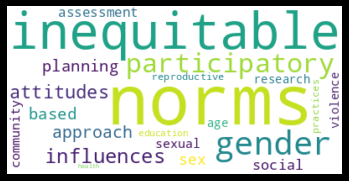

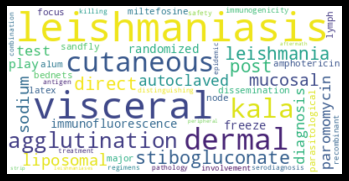

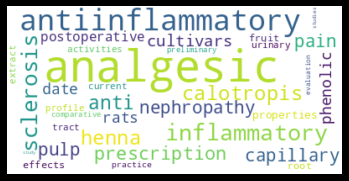

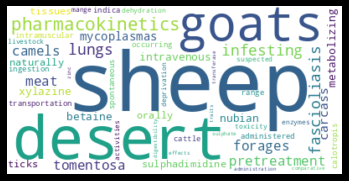

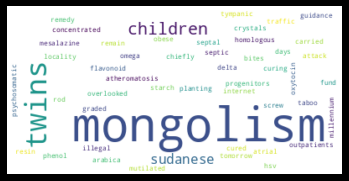

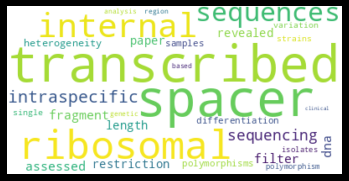

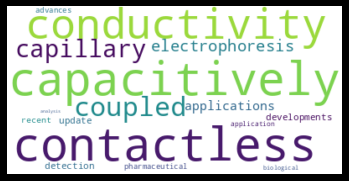

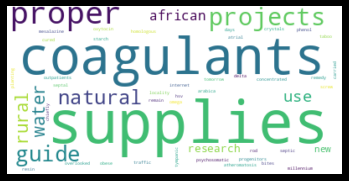

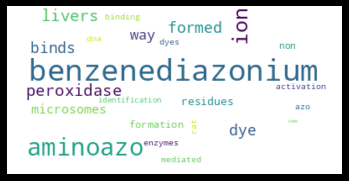

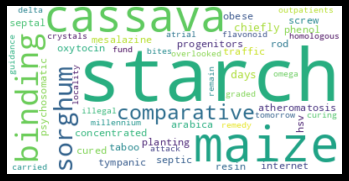

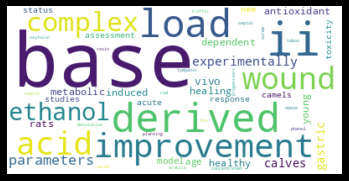

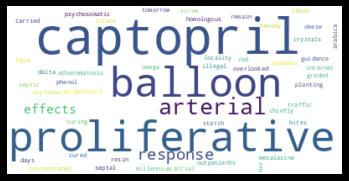

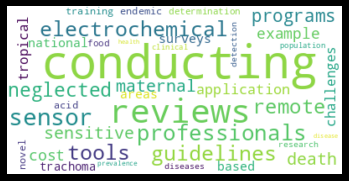

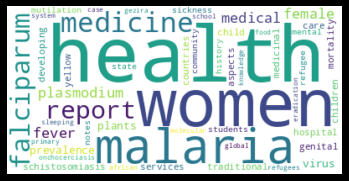

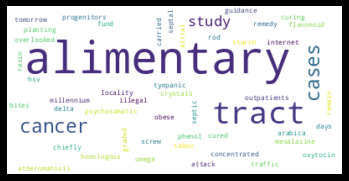

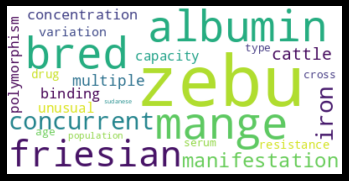

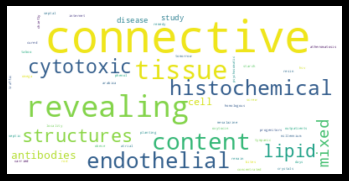

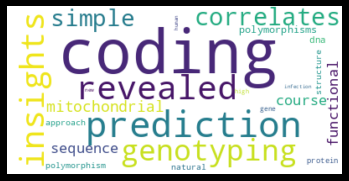

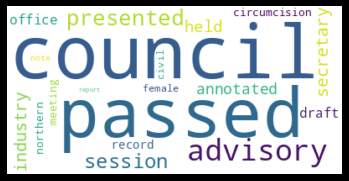

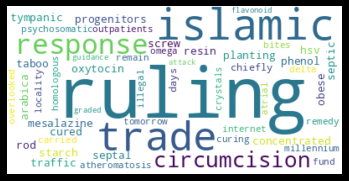

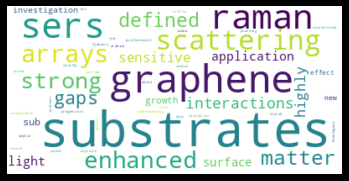

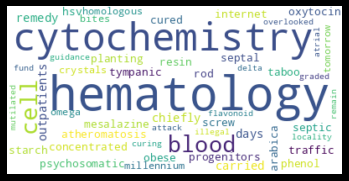

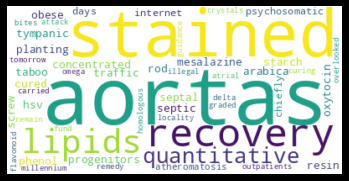

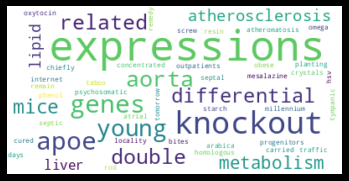

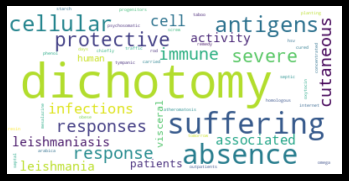

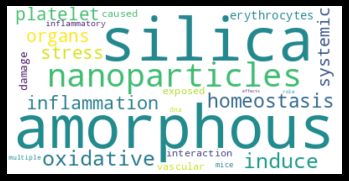

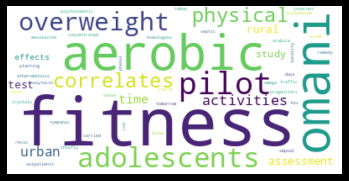

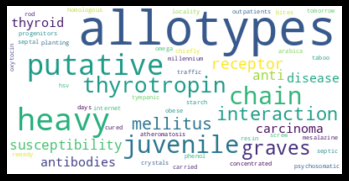

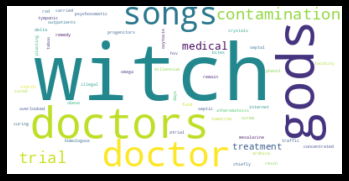

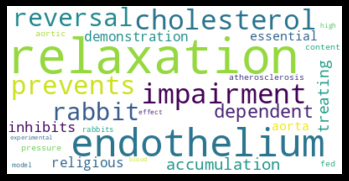

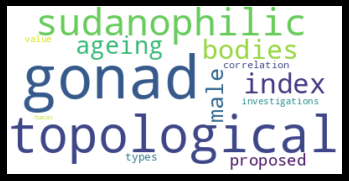

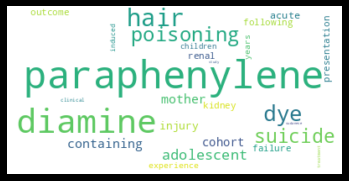

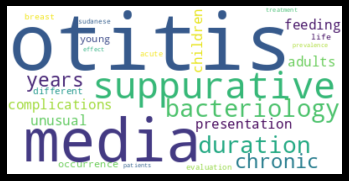

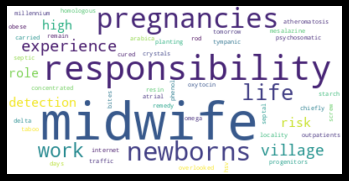

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def frequencies_dict(cluster_index):
    if cluster_index > k - 1:
        return
    term_frequencies = kmeans.cluster_centers_[cluster_index]
    sorted_terms = centroids[cluster_index]
    frequencies = {terms[i]: term_frequencies[i] for i in sorted_terms}
    return frequencies
def makeImage(frequencies):

    wc = WordCloud(background_color="white", max_words=50)
    # generate word cloud
    wc.generate_from_frequencies(frequencies)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
for i in range(k):
    freq = frequencies_dict(i)
    makeImage(freq)
    print()

##Topic Modeling

In [ ]:
# Importing gensim related libraries
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary
from gensim.models import Phrases
from collections import Counter
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer= WordNetLemmatizer()
from nltk.corpus import wordnet

In [ ]:
def get_pos_tag(tag):
    """This function is used to get the part-of-speech(POS) for lemmatization"""

    if tag.startswith('N') or tag.startswith('J'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN #default case

In [ ]:
import re
def preprocess(text):
    """ 1. Removes Punctuations
        2. Removes words smaller than 3 letters
        3. Converts into lowercase
        4. Lemmatizes words
        5. Removes Stopwords
    """
    nltk.download('punkt')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('wordnet')
    punctuation= list(string.punctuation)
    doc_tokens= nltk.word_tokenize(text)
    word_tokens= [word.lower() for word in doc_tokens if not (word in punctuation or len(word)<=3)]

    # Lemmatize
    pos_tags=nltk.pos_tag(word_tokens)
#     print(pos_tags)
    doc_words=[wordnet_lemmatizer.lemmatize(word, pos=get_pos_tag(tag)) for word, tag in pos_tags]
    doc_words= [word for word in doc_words if word not in stopwords]

    return doc_words

df_clean = df2['TITLE'].apply(preprocess)
df_clean.head()

Streaming output truncated to the last 5000 lines.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data

0    [female, genital, cut, infertility, nejm, jour...
2                                              [sudan]
3                              [false, prophet, sudan]
4                      [chemotherapy, trypanosomiasis]
5                                 [egypt, sudan, 1908]
Name: TITLE, dtype: object

In [ ]:
# Tried multiple parts of speech and obtained best topic results using Nouns and Adjectives!
def get_nouns_adjs(series):

    " Topic Modeling using only nouns and adjectives"

    pos_tags= nltk.pos_tag(series)
    all_adj_nouns= [word for (word, tag) in pos_tags if (tag=="NN" or tag=="NNS" or tag=="JJ")]
    return all_adj_nouns

df_nouns_adj = df_clean.apply(get_nouns_adjs)

In [ ]:
docs= list(df_nouns_adj)
phrases = gensim.models.Phrases(docs, min_count=10, threshold=20)
bigram_model = gensim.models.phrases.Phraser(phrases)

In [ ]:
def make_bigrams(texts):
    return [bigram_model[doc] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(docs)

In [ ]:
# Checkout most frequent bigrams :
bigram_counter1= Counter()
for key in phrases.vocab.keys():
    if key not in stopwords:
        if len(str(key).split('_'))>1:
            bigram_counter1[key]+=phrases.vocab[key]

for key, counts in bigram_counter1.most_common(20):
    print(key,">>>>", counts)

southern_sudan >>>> 221
eastern_sudan >>>> 208
south_sudan >>>> 185
visceral_leishmaniasis >>>> 184
plasmodium_falciparum >>>> 167
female_circumcision >>>> 119
anglo-egyptian_sudan >>>> 113
state_sudan >>>> 111
sudanese_child >>>> 104
falciparum_malaria >>>> 100
sudanese_patient >>>> 97
central_sudan >>>> 96
sudanese_woman >>>> 94
female_genital >>>> 86
khartoum_sudan >>>> 86
health_care >>>> 86
khartoum_state >>>> 82
risk_factor >>>> 81
leishmaniasis_sudan >>>> 79
medicinal_plant >>>> 79


In [ ]:
w2vmodel = Word2Vec(bigram_model[docs], vector_size =100, sg=1, hs= 1, seed=33, epochs=35, negative=0)

In [ ]:
#Feeding the bigrams into a Word2Vec model produces more meaningful bigrams

bigram_counter = Counter()
model = w2vmodel.wv.key_to_index.keys()
for key in model:
    if str(key) not in stopwords:
        if len(str(key.split("_"))) > 1:
            bigram_counter[key] += w2vmodel.wv.get_vecattr(key, "count")

for key, counts in bigram_counter.most_common(30):
    print(key,">>>>> " ,counts)

sudan >>>>>  3857
sudanese >>>>>  937
study >>>>>  914
effect >>>>>  581
patient >>>>>  497
infection >>>>>  463
disease >>>>>  458
child >>>>>  400
health >>>>>  395
treatment >>>>>  338
human >>>>>  327
malaria >>>>>  307
case >>>>>  295
population >>>>>  289
southern >>>>>  288
woman >>>>>  270
eastern >>>>>  268
africa >>>>>  260
prevalence >>>>>  252
khartoum >>>>>  251
african >>>>>  248
report >>>>>  247
analysis >>>>>  238
south >>>>>  234
control >>>>>  226
cell >>>>>  221
development >>>>>  220
country >>>>>  218
virus >>>>>  216
clinical >>>>>  214


In [ ]:
# MostOften mentioned along with the word 'female'
w2vmodel.wv.most_similar(positive= [b'pregnant'])

[('co-infection', 0.4348364472389221),
 ('pulmonary', 0.3511575758457184),
 ('tuberculin', 0.3499297499656677),
 ('pcr-based', 0.3277873694896698),
 ('trachoma', 0.32539358735084534),
 ('presentation', 0.3251001238822937),
 ('procedure', 0.3216661512851715),
 ('kassala', 0.31732699275016785),
 ('obstruction', 0.3081705570220947),
 ('compliance', 0.30766984820365906)]

In [ ]:
w2vmodel.wv.most_similar([b'female',b'pregnant'], [b'malaria'], topn=5)

[('eumycetoma', 0.4285132586956024),
 ('centre', 0.4111132025718689),
 ('co-infection', 0.3928632140159607),
 ('brief', 0.3919372260570526),
 ('clinical_presentation', 0.3898307979106903)]

In [ ]:
#Create a dictionary and corpus for input to our LDA model. Filter out the most common and uncommon words.
dictionary= Dictionary(data_words_bigrams)
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.6)
#processed_docs = [d.split() for d in docs]
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 774
Number of documents: 13153


In [ ]:
from gensim.models.ldamulticore import LdaMulticore
import time
t0= time.time()
passes= 150
np.random.seed(1) # setting up random seed to get the same results
ldamodel= LdaMulticore(corpus,
                    id2word=dictionary,
                    num_topics=40,
#                   alpha='asymmetric',
                    chunksize= 4000,
                    batch= True,
                    minimum_probability=0.001,
                    iterations=350,
                    passes=passes)

t1= time.time()
print("time for",passes," passes: ",(t1-t0)," seconds")

time for 150  passes:  566.5198366641998  seconds


In [ ]:
ldamodel.show_topics(num_words=12, formatted=False)

[(11,
  [('leishmaniasis', 0.31712067),
   ('sudan', 0.11603301),
   ('experience', 0.109307386),
   ('variation', 0.050524052),
   ('possible', 0.041416712),
   ('focus', 0.027341876),
   ('tropic', 0.024858199),
   ('versus', 0.024030095),
   ('survival', 0.024029981),
   ('kala-azar', 0.02387516),
   ('stage', 0.023201987),
   ('center', 0.022373933)]),
 (5,
  [('development', 0.21068819),
   ('evaluation', 0.16472471),
   ('atherosclerosis', 0.07567146),
   ('receptor', 0.060349308),
   ('trypanosomiasis', 0.05747723),
   ('trypanosoma', 0.04398744),
   ('aortic', 0.029708013),
   ('gambiense', 0.027792819),
   ('mouse', 0.027397994),
   ('image', 0.025877628),
   ('evolution', 0.025877351),
   ('train', 0.023004731)]),
 (6,
  [('endemic', 0.06639989),
   ('mutilation', 0.062197108),
   ('toxicity', 0.05591943),
   ('implication', 0.055045005),
   ('female', 0.054151148),
   ('production', 0.053298883),
   ('epidemiological', 0.045770925),
   ('approach', 0.04525568),
   ('study', 

In [ ]:
num_topics = 40
topic_words = []
for i in range(num_topics):
  tt = ldamodel.get_topic_terms(i, 12)
  topic_words.append([dictionary[pair[0]] for pair in tt])

In [ ]:
for i in range(num_topics):
     print(f'Topic {i} :'+ f'{topic_words[i]}')

Topic 0 :['population', 'cattle', 'sudanese', 'exposure', 'stress', 'pulmonary', 'susceptibility', 'measurement', 'host', 'infant', 'study', 'theileria', 'parasite', 'particle', 'nubia', 'protective', 'mellitus', 'import', 'induce', 'repeat']
Topic 1 :['child', 'prevalence', 'survey', 'sudanese', 'sudan', 'aspect', 'high', 'result', 'malnutrition', 'serological', 'factor', 'risk', 'young', 'affect', 'school', 'morbidity', 'illness', 'mitochondrial', 'performance', 'adolescent']
Topic 2 :['effect', 'level', 'acid', 'seed', 'year', 'reference', 'protein', 'republic', 'content', 'concentration', 'sudan', 'response', 'chick', 'plasma', 'dietary', 'normal', 'composition', 'metabolic', 'brain', 'growth']
Topic 3 :['observation', 'food', 'sudan', 'quality', 'kala-azar', 'life', 'dye', 'kenya', 'data', 'vector', 'upper', 'intervention', 'nile', 'famine', 'use', 'determination', 'need', 'presence', 'project', 'water']
Topic 4 :['sudan', 'pattern', 'anglo-egyptian', 'history', 'university', 'stu

In [ ]:
lda_corpus= ldamodel[corpus]

In [ ]:
# Obtaining the main topic for each review:

all_topics = ldamodel.get_document_topics(corpus)
num_docs = len(all_topics)

all_topics_csr= gensim.matutils.corpus2csc(all_topics)
all_topics_numpy= all_topics_csr.T.toarray()

major_topic= [np.argmax(arr) for arr in all_topics_numpy]
df2['major_lda_topic']= major_topic
df2.to_csv('/content/drive/MyDrive/Colab_Notebooks/Bibliography_DOCID.csv')

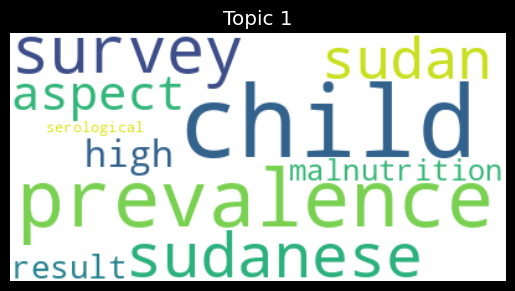

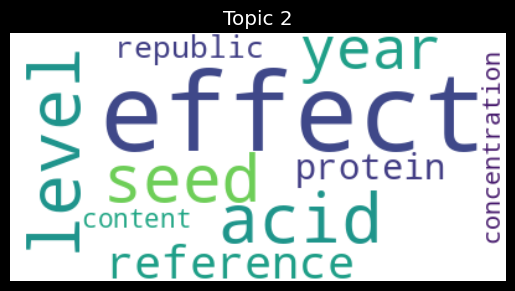

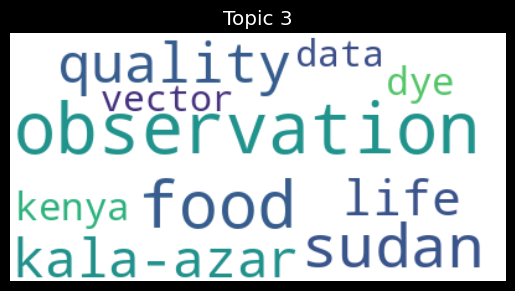

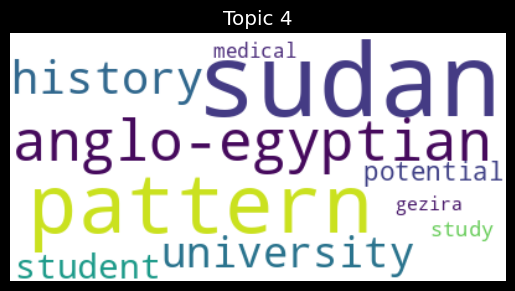

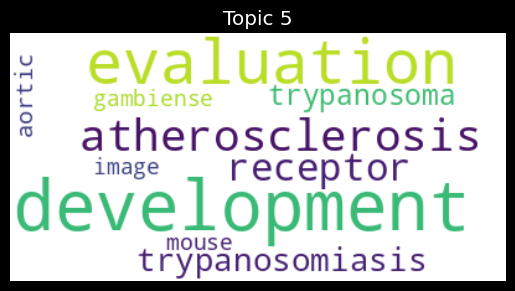

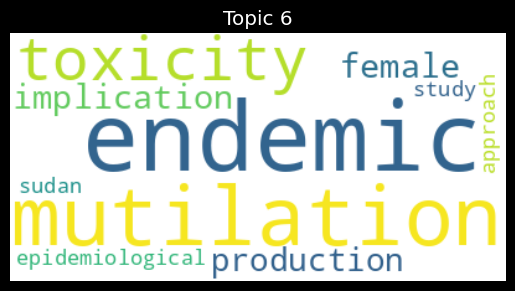

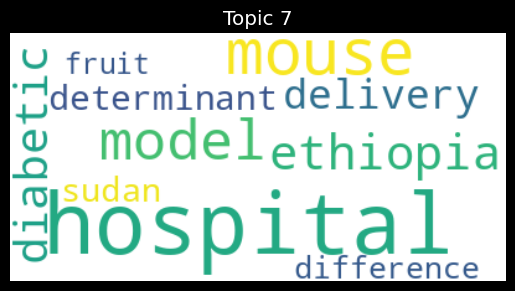

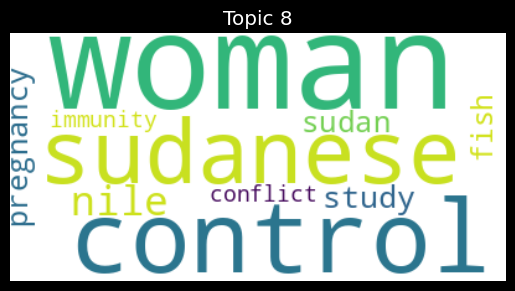

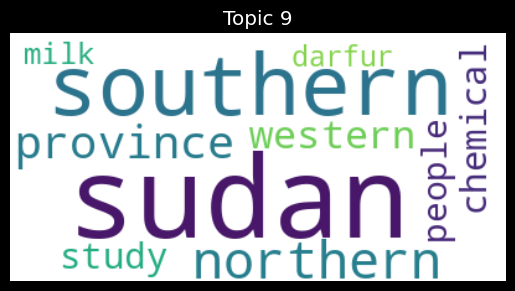

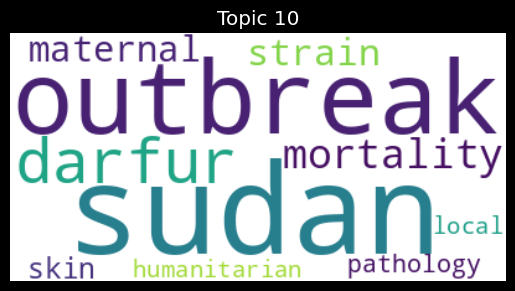

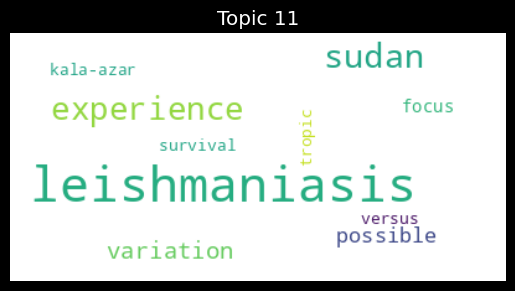

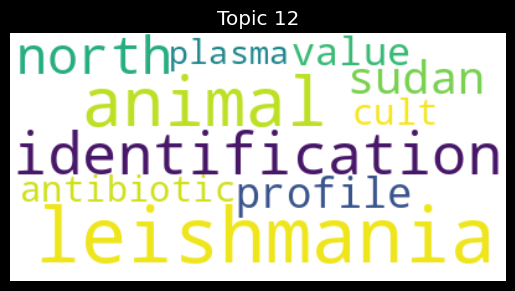

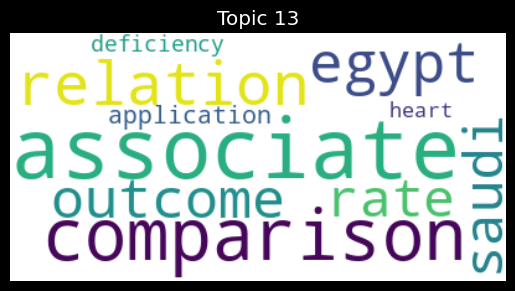

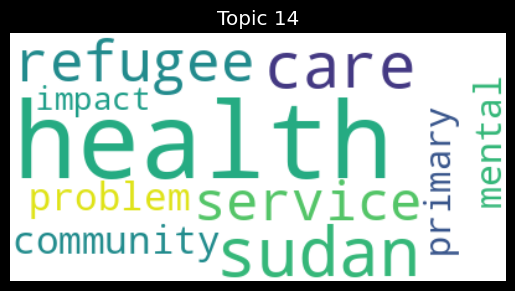

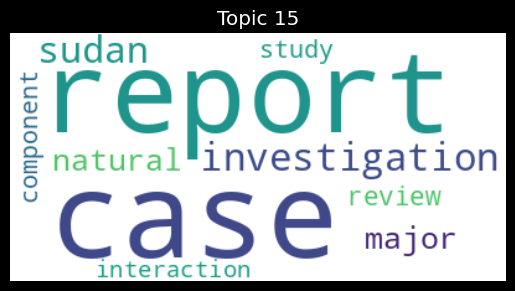

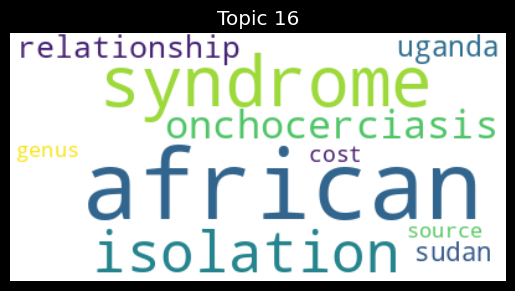

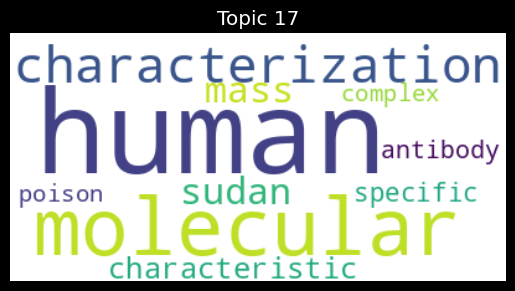

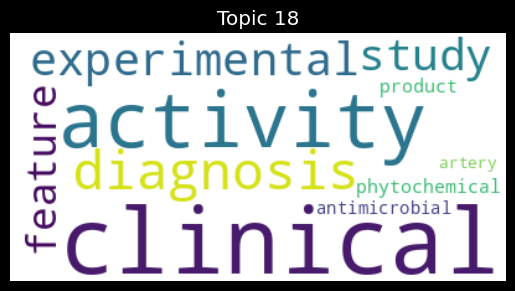

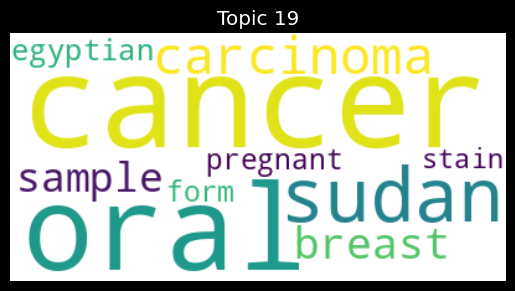

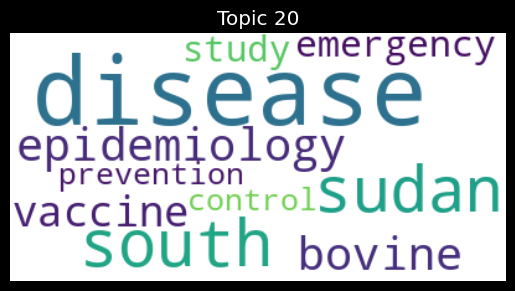

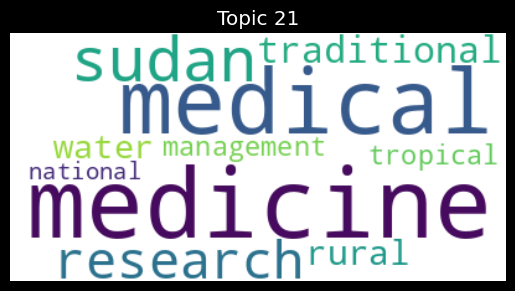

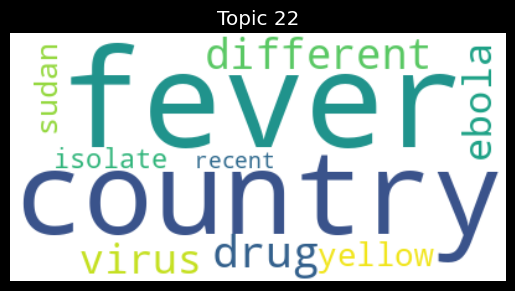

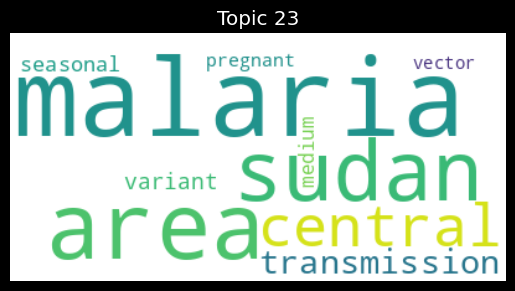

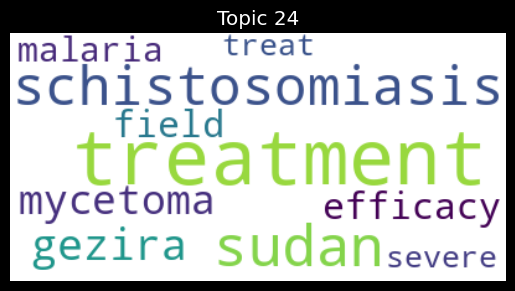

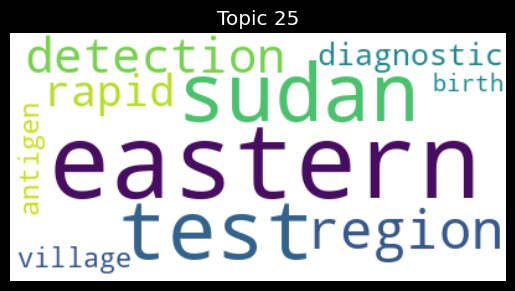

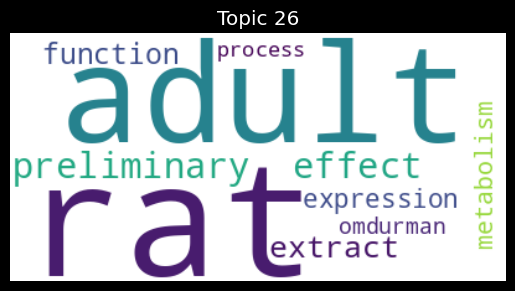

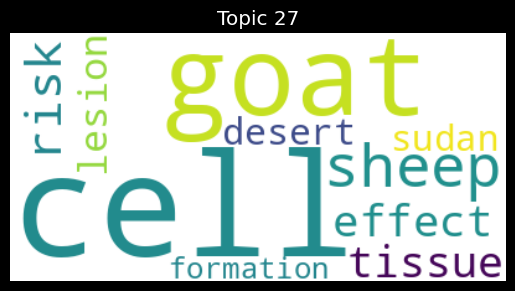

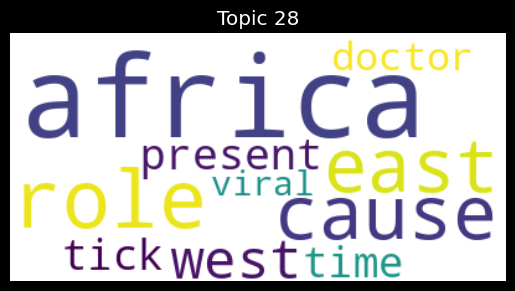

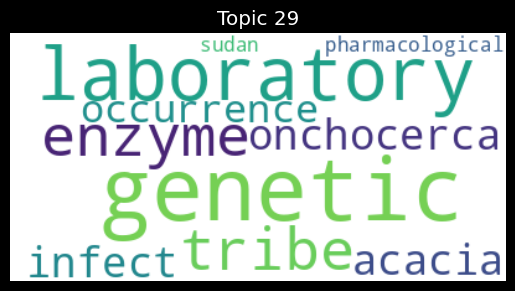

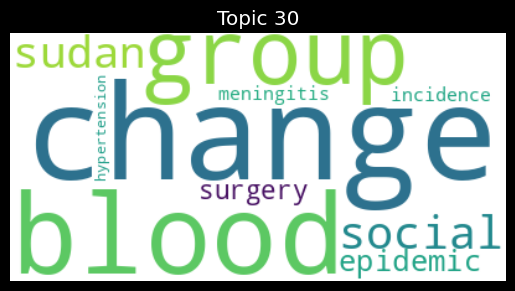

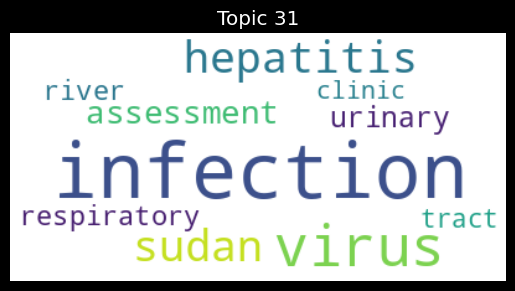

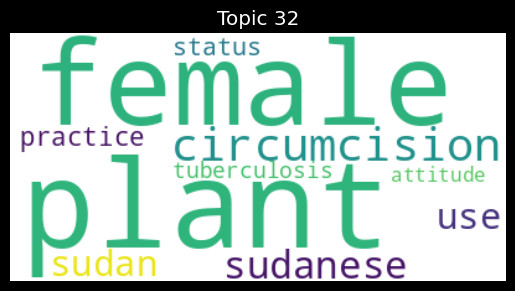

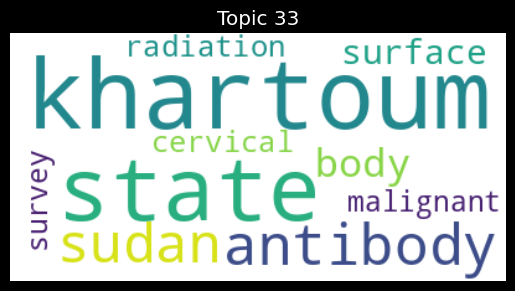

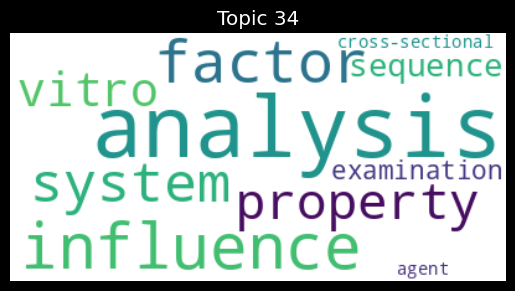

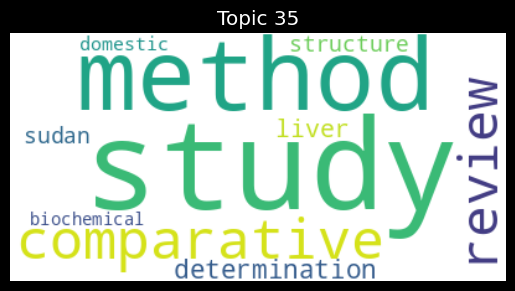

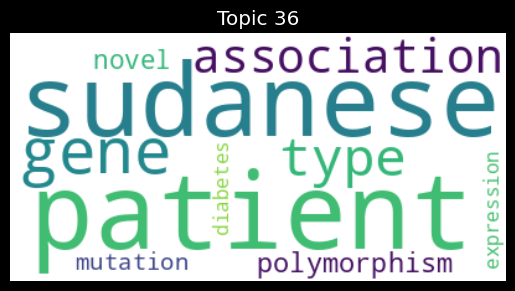

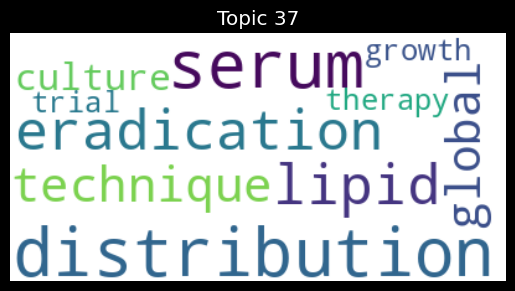

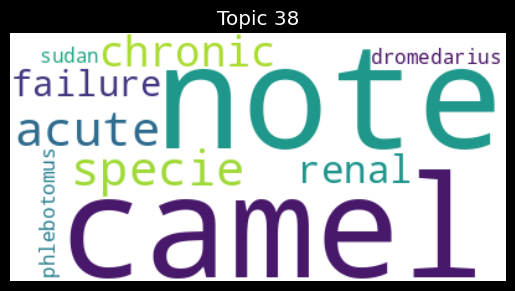

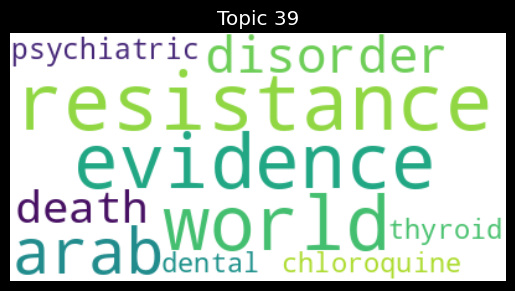

In [ ]:
#@title Topic Wordcloud
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.show_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " "+ str(topic))
    plt.show()

for i in range(1,40):
    create_wordcloud(ldamodel, topic=i)

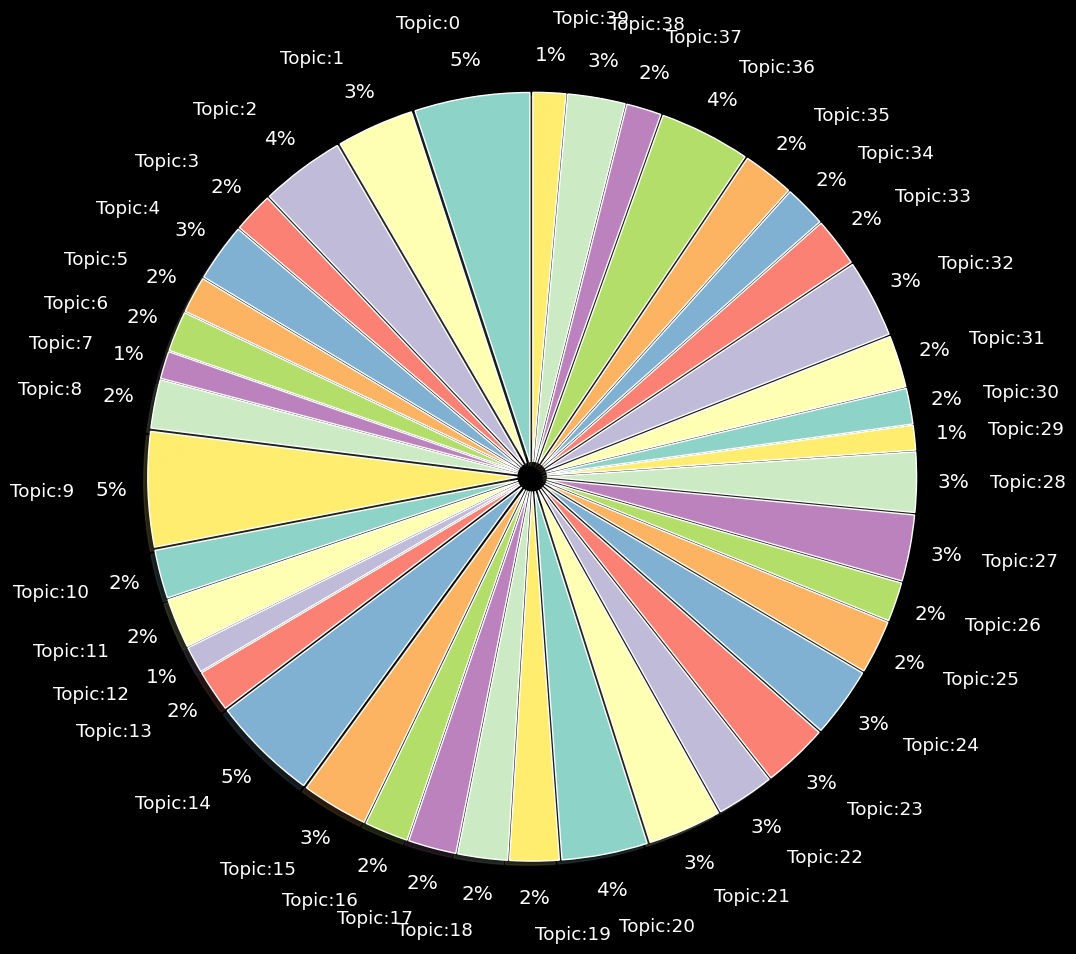

'def pie_chart(nm_topic):\n  dom_topic = []\n  labels = []\n  for i in nm_topic:\n    if\n    '

In [ ]:
#df2.groupby('major_lda_topic').count()
#df2.major_lda_topic.value_counts(normalize=True)
data= df2.major_lda_topic.value_counts(normalize=True).sort_index(axis=0)
nm_topic = range(0,40)
labels = [f'Topic:{str(topic)}' for topic in nm_topic]
explode = [0.1 for x in nm_topic]
plt.pie(data, labels = labels, autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, radius=2.5, startangle=90, shadow=True,explode= explode)
plt.show()
"""def pie_chart(nm_topic):
  dom_topic = []
  labels = []
  for i in nm_topic:
    if
    """

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Bibliography_DOCID.csv')
data2 = df2.major_lda_topic.value_counts(normalize=True)
print(data2)

0     0.050255
9     0.050103
14    0.046301
36    0.039611
20    0.037406
2     0.036646
32    0.033909
1     0.033681
21    0.032008
24    0.030563
27    0.028967
15    0.028967
23    0.028511
28    0.026154
4     0.025393
38    0.025089
22    0.025089
25    0.023341
31    0.022656
35    0.022504
11    0.021744
18    0.021668
19    0.021440
33    0.021288
8     0.021212
10    0.021136
17    0.020984
16    0.019083
13    0.018399
34    0.018247
6     0.017563
3     0.017563
26    0.017106
5     0.015966
30    0.015586
37    0.015206
39    0.014293
7     0.011936
12    0.011632
29    0.010796
Name: major_lda_topic, dtype: float64


In [ ]:
df3 = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Bibliography_DOCID.csv')
df3['DOC_ID']= df3['Unnamed: 0']
df3['topic_weight'] = data2
# Reorient from long to wide
dtm = df3.pivot(index='DOC_ID', columns='major_lda_topic', values='topic_weight').fillna(0)

# Divide each value in a row by the sum of the row to normalize the values
dtm = (dtm.T/dtm.sum(axis=1)).T
#print(dtm)
#df3['norm_topic_weight'] = dt_norm
# Shift back to a long dataframe
dt_norm = dtm.stack().reset_index()
dt_norm.columns = ['TOPIC_ID', 'major_lda_topic', 'norm_topic_weight']
df3 = df3.merge(dt_norm, on="major_lda_topic", how="left")
df3.head()

Unnamed: 0  Record Number Author Year  \
0           0          17394    NaN  NaN   
1           0          17394    NaN  NaN   
2           0          17394    NaN  NaN   
3           0          17394    NaN  NaN   
4           0          17394    NaN  NaN   

                                               TITLE   Reference Type Journal  \
0  female genital cutting and infertility - nejm ...  journal article     NaN   
1  female genital cutting and infertility - nejm ...  journal article     NaN   
2  female genital cutting and infertility - nejm ...  journal article     NaN   
3  female genital cutting and infertility - nejm ...  journal article     NaN   
4  female genital cutting and infertility - nejm ...  journal article     NaN   

  Volume Pages                                           Abstract  \
0    NaN   NaN  female genital cutting (fgc; also called femal...   
1    NaN   NaN  female genital cutting (fgc; also called femal...   
2    NaN   NaN  female genital cutting (fgc; also called femal...   
3    NaN   NaN  female genital cutting (fgc; also called femal...   
4    NaN   NaN  female genital cutting (fgc; also called femal...   

                 Keywords                             processed_title  \
0  female genital cutting  female genital cutting infertility journal   
1  female genital cutting  female genital cutting infertility journal   
2  female genital cutting  female genital cutting infertility journal   
3  female genital cutting  female genital cutting infertility journal   
4  female genital cutting  female genital cutting infertility journal   

   major_lda_topic  DOC_ID  topic_weight  TOPIC_ID  norm_topic_weight  
0               32       0      0.050255         0                1.0  
1               32       0      0.050255         2                0.0  
2               32       0      0.050255         3                0.0  
3               32       0      0.050255         4                0.0  
4               32       0      0.050255         5                0.0

In [ ]:
# Get number of docs per year
total_docs = df3.groupby('Year')['DOC_ID'].apply(lambda x: len(x.unique())).reset_index()
total_docs.columns = ['Year', 'total_docs']

# Group by year and topic id
df_avg = df3.groupby(['Year', 'major_lda_topic']).agg({'norm_topic_weight': 'sum'}).reset_index()

# Merge dataframes
df_avg = df_avg.merge(total_docs, on="Year", how="left")

# Compute the mean per topic
df_avg['average_weight'] = df_avg['norm_topic_weight'] / df_avg['total_docs']

# Merge the dataframes
labels = df3[['TITLE','major_lda_topic']]
df_avg = df_avg.merge(labels, on='major_lda_topic')

# # Limit to sample
#df_avg = df_avg[(df_avg['Year'] >= "1996") & (df_avg['Year']<= "2016")]
#dfs_avg = df_avg[(df_avg['major_lda_topic'] >= 0) & (df_avg['major_lda_topic']<= 9)]

In [ ]:
a_year= pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Copy_of_Author_paper.csv')
# Get number of docs per year
a_year["major_lda_topic"] = df3["major_lda_topic"]
a_year['Author_split']=a_year['Author'].apply(lambda x: x.replace("'", "").strip('][').split(', '))
df_author = a_year.explode('Author_split')
#df_author['Year'] = df3['Year']
df_author['norm_topic_weight'] = df3['norm_topic_weight']
total_docs = df_author.groupby('Author_split')['major_lda_topic'].apply(lambda x: len(x.unique())).reset_index()
total_docs.columns = ['Author_split', 'total_docs']
df_avg = df_author.groupby(['Author_split', 'major_lda_topic']).agg({'norm_topic_weight': 'sum'}).reset_index()
# Merge dataframes
df_avg = df_avg.merge(total_docs, on="Author_split", how="left")
labels = a_year[['Author_split','DOC_ID']]
labels = labels.astype(str)
df_avg = df_avg.merge(labels, on="Author_split", how="left")
# Limit to sample
#df_avg = df_avg[(df_avg['Author_split'] >= "a. m. elhassan") & (df_avg['Author_split'] <= "a. m. elhassan") ] # El Hassan waterston
#df_avg = df_avg[(df_avg['Year'] >= "1980") & (df_avg['Year']<= "2000")]

In [ ]:
df_avg.sort_values(by=['Author_split'])
df_avg['Author_split'].head()

0     Unknown author
1     Unknown author
2      a. a. babiker
3     a. m. elhassan
4     a. m. g. e. a.
Name: Author_split, dtype: object

In [ ]:
df_avg3= df_avg[(df_avg['Author_split'].str.strip().str.lower().str.replace(" ",'') == "a. m. elhassan".strip().lower().replace(" ",'')) ]
df_avg3.head()

Author_split  major_lda_topic  norm_topic_weight  total_docs DOC_ID
2605   a. m. el hassan               10                0.0           4    NaN
2606   a. m. el hassan               14                0.0           4    NaN
2607   a. m. el hassan               15                0.0           4    NaN
2608   a. m. el hassan               37                0.0           4    NaN
2655    a. m. elhassan                9                0.0           4    NaN

In [ ]:
df_avg2= df_avg[(df_avg['Author_split'].str.strip().str.lower().str.replace(" ",'') == "El Hassan".strip().lower().replace(" ",''))]
df_avg2.head()

Author_split  major_lda_topic  norm_topic_weight  total_docs DOC_ID
38309    el hassan                9                0.0           3    NaN
38310    el hassan               10                4.0           3    NaN
38311    el hassan               20                1.0           3    NaN
38486     elhassan               28                1.0           2    NaN
38487     elhassan               30                0.0           2    NaN

In [ ]:
df_avg = df_avg.drop_duplicates(subset=['Year'])
df_avg = df_avg.sort_values(by='Year', ascending=False)
df_reverse_rows = df_avg.iloc[::-1]
df_reverse_rows.head()

Year  major_lda_topic  norm_topic_weight  total_docs  average_weight  \
0        1043               26                0.0           1             0.0   
567000    169               39                0.0           1             0.0   
1040760  1709                0                3.0           1             3.0   
4028480  1710                1                2.0           1             2.0   
5428360  1790                2                1.0           1             1.0   

                                                     TITLE  
0        phytochemistry and biological activity of khay...  
567000   arab world asks for help, but will family plan...  
1040760                      smallpox 70 per cent reduced]  
4028480  malnutrition in sudanese children as a functio...  
5428360  dietary fat intake, 72-hour excretion, and sud...

In [ ]:
df_avg2 = df_avg2.append(df_avg3)
#df_avg2 = df_avg2.drop_duplicates(subset=['major_lda_topic'])
df_avg2 = df_avg2.sort_values(by='major_lda_topic', ascending=False)
df_reverse_rows = df_avg2.iloc[::-1]
df_avg2.head()
df_reverse_rows.head()

<ipython-input-23-cde12b591a89>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_avg2 = df_avg2.append(df_avg3)


Author_split  major_lda_topic  norm_topic_weight  total_docs DOC_ID
38309         el hassan                9                0.0           3    NaN
38310         el hassan               10                4.0           3    NaN
2606    a. m. el hassan               14                0.0           4    NaN
2607    a. m. el hassan               15                0.0           4    NaN
38311         el hassan               20                1.0           3    NaN

Text(0, 0.5, '')

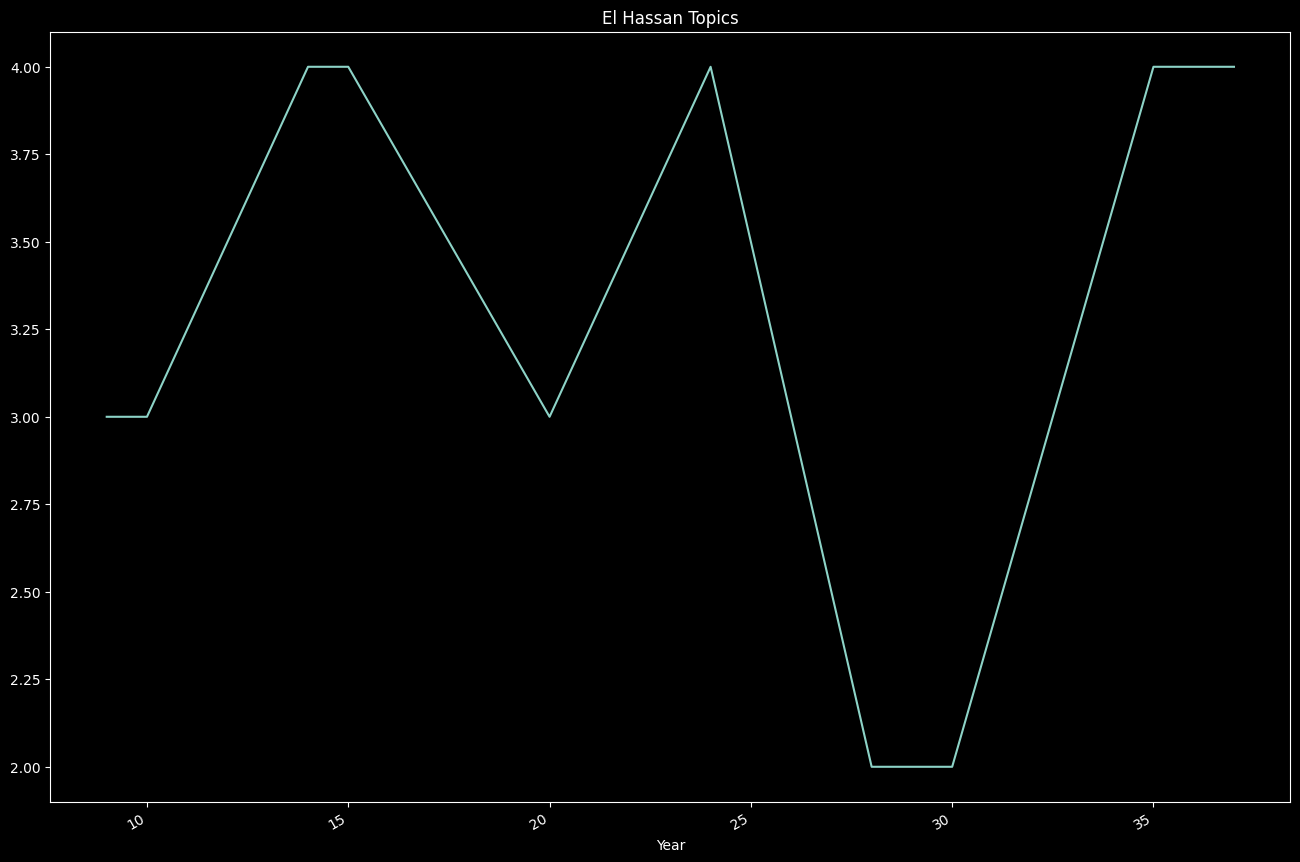

In [ ]:
import seaborn as sns
#dfs_avg = df_avg[(df_avg['major_lda_topic'] == 20)] #topic(0,9,14,36)
# Plotting the time series of given dataframe
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#plt.plot(df_avg2.Year, df_avg2.Author_split)
#,hue='Author_split'
#sns.countplot(x ='major_lda_topic', data=df_avg2,width=2)
plt.plot(df_avg2.major_lda_topic, df_avg2.total_docs)
# Plot the time series data as a bar plot
plt.xticks(rotation=90)
# Giving title to the chart using plt.title
plt.title('El Hassan Topics')
# rotating the x-axis tick labels at 30degree
# towards right
plt.xticks(rotation=30, ha='right')
fig = plt.gcf()
fig.set_size_inches( 16, 10)
# Providing x and y label to the chart
plt.xlabel('Year')
plt.ylabel('')

#Analyze K-means Clustering against Topic Labeling

<Axes: >

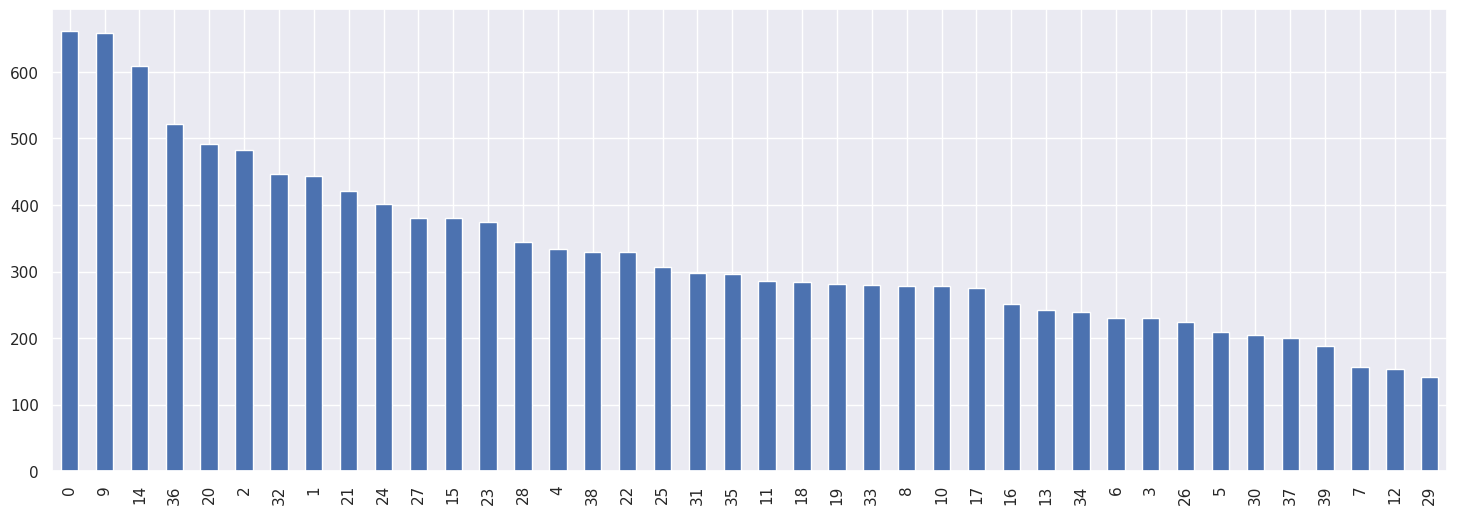

In [ ]:
import seaborn as sns
sns.set(rc= {'figure.figsize': (18,6)})
sns.set_style('darkgrid')

df2.major_lda_topic.value_counts().plot(kind='bar')